<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/multivariate_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!git clone https://github.com/Krankile/npmf.git

##General setup

In [140]:
%%capture
!cd npmf && git pull
from npmf.utils.colors import main,main2,main3

In [4]:
#!pip install 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [6]:
np.random.seed(420)

#Lets build our multivariate experiment 😂✨KAWAIII ^^✨ 

## 1) Build timeseries dataframe 🎶🐱‍🚀

Define some function to easily generate many timeseries $y_t$ 

In [7]:
def wave_function(periods, horisontal_shift, vertical_shift, T):
    x = np.linspace(horisontal_shift,T+horisontal_shift,T)
    
    return np.sin(np.pi*periods*2*x)*(1-vertical_shift) + vertical_shift 

Visualise the function

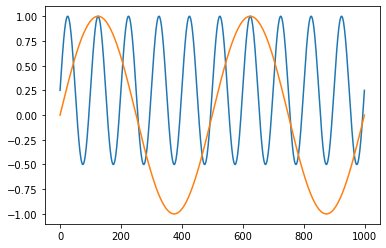

In [8]:
periods = 10
horisontal_shift = 100
vertical_shift = .25
T = 1000


plt.plot(wave_function(periods, horisontal_shift, vertical_shift, T))
plt.plot(wave_function(2, horisontal_shift, 0, T));

Make an outer to create $\mathcal{S}:\{y_t^1,y_t^2...y_t^k$\}, $|\mathcal{S}|=K$ we should also have $\mathcal{S_{sub}} \in \mathcal{S} | |y_t^i-y_t^j|, (i\neq j)$ 

In [ ]:
#TODO

Now we create a dataframe of $\mathcal{S}$ with indistingushable timeseries with distingushable $y_{t+h}$

In [9]:
from numpy.ma.core import outerproduct
def time_series_df(K,T, periods, horisontal_shift, vertical_shift, forecast_length):
    series = []
    output_series = [np.array([1 for i in range(forecast_length)]),
                     np.array([2*i for i in range(forecast_length)]),
                     np.array([2**i*(-1**i) for i in range(forecast_length)])]
    for j in range(len(output_series)):
        output_series[j] = output_series[j]/max(abs(output_series[j]))  
    
    for i in range(K):
        series.append(wave_function(periods, horisontal_shift, vertical_shift,T))
    TS_signal_df = pd.DataFrame(series)
    
    #add noise
    mu, sigma = 0, 0.1  
    noise = np.random.normal(mu, sigma, [K,T]) 
    
    TS_df = TS_signal_df + noise
    
    output_df = pd.DataFrame(int(K/3)*output_series,columns=[f"forecast_{x}" for x in range(forecast_length)])
    category_columns = pd.get_dummies(pd.Series(int(K/3)*["theta_0", "theta_1", "theta_2"], name="category",dtype="category"))


    TS_df = pd.concat([TS_df,output_df], join="inner",axis=1)
    TS_signal_df = pd.concat([TS_signal_df,output_df], join="inner",axis=1)
    return TS_df, TS_signal_df, category_columns

example_below

In [10]:
K = 9999 #make divisible by three
T = 500
forecast_length = 16

periods = 10
horisontal_shift = 100
vertical_shift = .25

TS_df, TS_signal_df, category_columns  = time_series_df(K,T,periods, horisontal_shift, vertical_shift, forecast_length)

In [102]:
TS_signal_df
pd.concat([category_columns, TS_signal_df], axis=1, join="inner") 

,theta_0,theta_1,theta_2,0,1,2,3,4,5,6,...,forecast_6,forecast_7,forecast_8,forecast_9,forecast_10,forecast_11,forecast_12,forecast_13,forecast_14,forecast_15
0,1,0,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.0
1,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0
2,0,0,1,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,-0.001953,-0.003906,-0.007812,-0.015625,-0.031250,-0.062500,-0.125,-0.250000,-0.500000,-1.0
3,1,0,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.0
4,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0
9995,0,0,1,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,-0.001953,-0.003906,-0.007812,-0.015625,-0.031250,-0.062500,-0.125,-0.250000,-0.500000,-1.0
9996,1,0,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.0
9997,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0


In [68]:
def min_search(one_d_points, loss_type, start, stop, iterations):
    min_loss = float("inf")
    min_y = None
    for y in np.linspace(start,stop,iterations):
        if loss_type == "abs":
            loss = np.abs(one_d_points-y).mean()
        else:
            loss = ((one_d_points-y)**2).mean()
        if loss < min_loss:
            min_loss = loss
            min_y = y
    return min_loss, min_y

def two_d_min_search(list_of_series, loss_type):
    min_losses = []
    ys = []
    for i in range(list_of_series[0].shape[0]):
        cross_sectional_min, y = min_search([list_of_series[0][i], list_of_series[1][i], list_of_series[2][i]], loss_type, -1, 1, 1000)
        min_losses.append(cross_sectional_min)
        ys.append(y)
    return np.array(min_losses), ys

0.3751661977172892


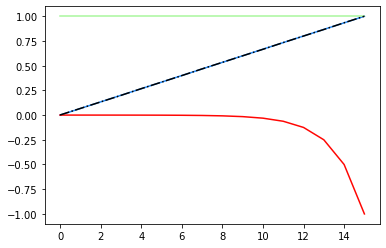

In [154]:
plt.plot(TS_df.iloc[1,-forecast_length:].values,color=main)
plt.plot(TS_df.iloc[2,-forecast_length:].values, color=main2)
plt.plot(TS_df.iloc[3,-forecast_length:].values, color=main3)

list_of_forecasts = [TS_df.iloc[0,-forecast_length:].values, TS_df.iloc[1,-forecast_length:].values, TS_df.iloc[2,-forecast_length:].values]

perfect_predict, ys = two_d_min_search(list_of_forecasts, "abs") 

mean_predict = (TS_df.iloc[1,-forecast_length:].values+TS_df.iloc[2,-forecast_length:].values+TS_df.iloc[3,-forecast_length:].values)/3

plt.plot(ys,linestyle="-.",color="black")

print(perfect_predict.mean())

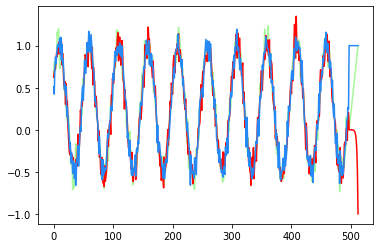

In [164]:
plt.plot(TS_df.iloc[1,3:].values, color=main3)
plt.plot(TS_df.iloc[2,3:].values, color=main2)
plt.plot(TS_df.iloc[3,3:].values, color=main);

All set 👍

## 2) Create a neural net 🦾🧠🦾                                     
                                        🦿🦿





In [86]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_size, out_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 512*2),
            nn.ReLU(),
            nn.Linear(512*2, 512),
            nn.ReLU(),
            nn.Linear(512, out_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## 3) Lets make a training loop 🤣❤ 

In [149]:
def train(model, optimizer, loss_fn, data_train, data_val, one_hot_encoding, batch_number, forecast_window, epochs):
    print(model)
    train_losses = []
    val_losses = []
    it = tqdm(range(epochs))
    for epoch in it: 
        for run_type in ["train", "val"]:
            
            if run_type == "train":
                model.train(True)
                optimizer.zero_grad()
                
                mu, sigma = 0, 0.1
                noise = np.random.normal(mu, sigma, data_train.shape)
                noise[:,-forecast_window:] = 0

                data_train = data_train + noise
                
                if one_hot_encoding is not None:
                    data_train_encoded = pd.concat([one_hot_encoding, data_train], axis=1, join="inner")
                else:
                    data_train_encoded = data_train                
                data_shuffled = torch.tensor(data_train_encoded.sample(frac=1).values, dtype=torch.float32) #remove tetha and scramble

            else:
                model.train(False)
                
                if one_hot_encoding is not None:
                    data_val_encoded = pd.concat([one_hot_encoding, data_val], axis=1, join="inner")
                else:
                    data_val_encoded = data_val

                data_shuffled = torch.tensor(data_val_encoded.sample(frac=1).values, dtype=torch.float32)
            
            for batch in torch.split(data_shuffled, batch_number, dim=0):
                
            
                inputs = batch[:,:-forecast_window]
                actuals = batch[:,-forecast_window:]

                
                pred = model(inputs)
                loss = loss_fn(pred, actuals)
                
                if run_type == "train":
                    #print(loss.item())
                    
                    train_losses.append(loss.item())
                    loss.backward()

                    optimizer.step()
                else:
                    #print(f"val loss:{np.mean(loss)}")
                    val_losses.append(loss.item())
        it.set_postfix({"train_loss": np.mean(train_losses), "val_loss": np.mean(val_losses)})

    return train_losses, val_losses




## 4) Finally run experiment

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [124]:
def run(use_multivariate):
    #Training loop params
    forecast_window = 16
    amount_of_time_series = 999
    length_of_time_series = 10
    epochs = 200
    
    #Wave params
    periods = 10
    horisontal_shift = 100
    vertical_shift = 0

    _, TS_signal, one_hot_encoding  = time_series_df(amount_of_time_series,length_of_time_series,periods, horisontal_shift, vertical_shift, forecast_window)

    df_train = TS_signal.iloc[-int(amount_of_time_series/3):,:]
    df_val = TS_signal.iloc[:-int(amount_of_time_series/3),:]

    loss_fn = nn.L1Loss()
    
    print(f"use_multivariate: {use_multivariate}")
    if use_multivariate:        
        model = NeuralNetwork(length_of_time_series + one_hot_encoding.shape[1], forecast_window)
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001) 
        return train(model, optimizer, loss_fn, df_train, df_val, one_hot_encoding, 3,forecast_window, epochs)
    
    else:
        model = NeuralNetwork(length_of_time_series, forecast_window)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        return train(model, optimizer, loss_fn, df_train, df_val, None, 3,forecast_window, epochs)


In [150]:
train_losses_multi, val_losses_multi = run(use_multivariate=True)
train_losses_uni, val_losses_uni = run(use_multivariate=False)

use_multivariate: True
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=16, bias=True)
  )
)


100%|██████████| 200/200 [04:43<00:00,  1.42s/it, train_loss=0.119, val_loss=0.099]


use_multivariate: False
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=16, bias=True)
  )
)


100%|██████████| 200/200 [04:32<00:00,  1.36s/it, train_loss=0.391, val_loss=0.392]


In [80]:
def rolling_mean(np_array, window_size):
    return np.convolve(np_array, np.ones(window_size)/window_size, mode='valid')

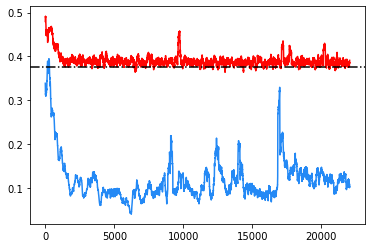

In [151]:
plt.plot(rolling_mean(train_losses_multi, 150),color=main);
plt.plot(rolling_mean(train_losses_uni, 150),color=main2);
plt.axhline(y=perfect_predict.mean(), color="black", linestyle='-.')
plt.show()

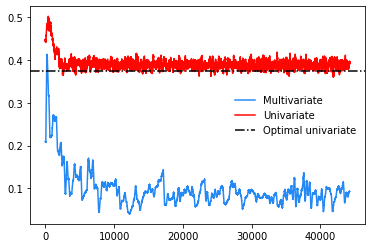

In [152]:
plt.plot(rolling_mean(val_losses_multi,150), color=main, label="Multivariate")
plt.plot(rolling_mean(val_losses_uni,150),color=main2, label="Univariate")
plt.axhline(y=perfect_predict.mean(), color='black', linestyle='-.', label="Optimal univariate")
plt.legend(frameon=False)
plt.show()

The train loss converges to ≈0.28, and the validation loss is the neural net does not have sufficient information of what the underlyding data generating process is. 

In [ ]:
np.mean(train_losses)

0.2828252570865832

In [ ]:
np.mean(val_losses)

0.3002939947319999